# Assignmet 4 - Sentiment Classification with Contextualized Models

This is a sentiment classifier based on pretrained BERT embeddings, with a self-designed finetuning layer. The classifier is trained and tested on the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/). 

It is followed by a baseline model from sci-kit learn: an SGD classifier on the reviews in tf-idf

For reference, I also added a transformer pipeline with a DistilBert model finetuned on text classification at the end.

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt


In [2]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 28.6 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |████████████████████████████████| 6.6 MB 60.4 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Fetch and format data

Fetch the data and create our X (data) and y (labels).

In [3]:
!wget -N https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2022-05-31 15:09:09--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  17.3MB/s    in 8.0s    

2022-05-31 15:09:18 (10.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [4]:
# untar the .tar.gz file
import tarfile
file = tarfile.open('aclImdb_v1.tar.gz')
file.extractall('./')
file.close

<bound method TarFile.close of <tarfile.TarFile object at 0x7f36735d5490>>

In [5]:
# store the reviews and their labels

def build_set(train_or_test, pos_or_neg):
  '''Stores the reviews in a particular file and their labels in lists'''
  folder = os.listdir(f'./aclImdb/{train_or_test}/{pos_or_neg}/')
  X_raw = []
  y = []
  if pos_or_neg == 'pos':
    binary = 1
  else:
    binary = 0
  for f in folder:    
    text = open(f'./aclImdb/{train_or_test}/{pos_or_neg}/{f}', 'r')
    X_raw.append(text.read())
    y.append(binary)
  return X_raw, y

def setup(train_or_test):
  '''Combine the positives and negatives. '''
  X_pos, y_pos = build_set(train_or_test, 'pos')
  X_neg, y_neg = build_set(train_or_test, 'neg')
  X = X_pos + X_neg
  y = y_pos + y_neg
  return X, y

In [6]:
X, y = setup('train')
X_test, y_test = setup('test')

## Dataset and Transformer model

The custom Dataset class and classifier class are created.

In [25]:
class ReviewDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings      # a dictionary-like object with all reviews in encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    '''Returns a dictionary that contains encodings, attention masks and labels of the indexed reviews. '''
    item = {key: val[idx] for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

In [26]:
class BERTSentiment(nn.Module):
  def __init__(self, lr=0.0001, n_epoch=1): 
    super().__init__()
    self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
    self._bert = BertModel.from_pretrained("bert-base-uncased")
    self._clf = nn.Sequential(nn.Linear(768, 1), nn.Sigmoid())
    self.lr = lr
    self.n_epoch = n_epoch
    if torch.cuda.is_available():
      self.cuda()
  
  def forward(self, X, attention_mask):
    _, c = self._bert(X, attention_mask=attention_mask, return_dict=False)      # c is a representation with 768 dimensions,
    return self._clf(c)                                                         # which is then passed through the Linear and Sigmoid function


  def fit(self, X, y):
    self.train()                                                                # training mode
    loss_function = nn.BCELoss()                                                # Binary Entropy Loss is used for our binary classification
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)                 

    self.training_loss_ = []                                                    # for plotting graphs
    self.training_accuracy_ = []

    self.batch_size = 16                                                        # 16 is just right to exploit the Colab GPU without crashing
    X_encoded = self.tokenizer(X, padding=True, truncation=True, return_tensors='pt')
    data = ReviewDataset(X_encoded, y)

    for epoch in range(self.n_epoch):                                           # loop over the full dataset. 1 epoch is good enough for training with 25000 reviews.
      with tqdm(DataLoader(data, batch_size=self.batch_size, shuffle=True), 
                total=len(X)//self.batch_size+1, unit="batch", desc="Epoch %i" % epoch) as batches:
        for batch in batches:
          optimizer.zero_grad()                                                 
          input_ids = batch['input_ids'].to('cuda')                             # pass data to the GPU
          attention_mask = batch['attention_mask'].to('cuda')
          labels = batch['labels'].reshape(-1,1).to('cuda')
          
          outputs = self(input_ids, attention_mask=attention_mask)              # Forward pass
          loss = loss_function(outputs.float(), labels.float())                 # float type is needed for BCELoss
          loss.backward()                                                       # Backpropagate the error
          optimizer.step()                                                      # Run the optimizer to change the weights

          predictions = [round(output[0]) for output in outputs.tolist()]       # to calculate accuracy
          n_correct = 0
          for i, pred in enumerate(predictions):
            if pred == labels[i,0]:
              n_correct += 1
          n_total = labels.size(dim=0)
          accuracy = 100*n_correct/n_total
          self.training_loss_.append(loss.item())
          self.training_accuracy_.append(accuracy)
          batches.set_postfix(loss=loss.item(), accuracy=accuracy)              # Update the progress bar
          gc.collect()
          torch.cuda.empty_cache()

  def score(self, X, y):
    self.eval()                                                                 # evaluation mode

    with torch.no_grad():                                                       # gradient not needed
      n_correct = 0
      n_total = len(y)
      self.predictions = []                                                     # can retrieve predictions if we want to

      X_encoded = self.tokenizer(X, padding=True, truncation=True, return_tensors='pt')
      data = ReviewDataset(X_encoded, y)

      for batch in tqdm(DataLoader(data, batch_size=self.batch_size)): 
          input_ids = batch['input_ids'].to('cuda')                             # pass data to the GPU
          attention_mask = batch['attention_mask'].to('cuda')
          labels = batch['labels'].reshape(-1,1).to('cuda')
          
          outputs = self(input_ids, attention_mask=attention_mask)              # Forward pass

          new_predictions = [round(output[0]) for output in outputs.tolist()]
          self.predictions.extend(new_predictions)
          for i, pred in enumerate(new_predictions):
            if pred == labels[i,0]:
              n_correct += 1                                                    # tabulate no. of correct predictions
    self.accuracy = n_correct/n_total                                           # can access accuracy as an attribute
    print("Test accuracy %.1f%%" % (100*self.accuracy))
    self.plot_loss_accuracy(X, y)

  def plot_loss_accuracy(self, X, y):
    '''To plot our accuracy and loss of our training process. '''
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot()
    ax.set_title("Plot for the loss over epochs")
    ax.plot(self.training_loss_, 'b-')
    ax.set_ylabel("Training Loss", color='b')
    ax.set_xlabel("Epoch")
    # ax.set_yscale('log')
    ax.tick_params(axis='y', labelcolor='b')
    ax = ax.twinx()
    ax.plot(self.training_accuracy_, 'r-')
    ax.set_ylabel("Accuracy [%]", color='r')
    ax.tick_params(axis='y', labelcolor='r')
    a = list(ax.axis())
    a[2] = 0
    a[3] = 100
    ax.axis(a)
    t = np.arange(0, len(self.training_accuracy_), len(X)//self.batch_size+1)
    ax.set_xticks(ticks=t)
    ax.set_xticklabels(labels=np.arange(len(t)))
    fig.tight_layout()
    plt.show()

Here we create and train our model.

In [27]:
gc.collect()
torch.cuda.empty_cache()
model = BERTSentiment()
model.fit(X, y)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch 0: 100%|██████████| 1563/1563 [48:05<00:00,  1.85s/batch, accuracy=87.5, loss=0.292]


100%|██████████| 1563/1563 [14:32<00:00,  1.79it/s]


Test accuracy 90.4%


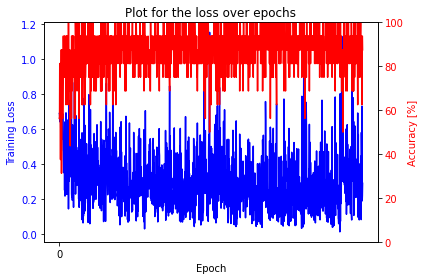

In [28]:
model.score(X_test, y_test)

Only one epoch is run, as it already takes 45 minutes to go through 25000 reviews.
The graph does not look very good, since it is calculated per batch (of size 16, maximum for the GPU to not run out of memory), the fluctuation of the loss and the accuracy are low.

## Baseline model: sklearn SGDClassifier with tf-idf

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X)                                                               # Creates the vocabulary of the vectorizer
X_vec = vectorizer.transform(X)                                                 # Vectorizes training data to tfidf
X_test_vec = vectorizer.transform(X_test)                                       # Vectorizes test data to tfidf                  

In [23]:
from sklearn.linear_model import SGDClassifier

reguliser_dampening = 0.001   # lambda
learning_rate = .1            # gamma

# Create the untrained classifier
model = SGDClassifier(loss='hinge', penalty='l2',
                      alpha=reguliser_dampening, verbose=1,
                      learning_rate='constant', eta0=learning_rate)

# Train the classifier
model.fit(X_vec, y)

-- Epoch 1
Norm: 17.76, NNZs: 70938, Bias: 0.145000, T: 25000, Avg. loss: 0.587410
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 18.01, NNZs: 71735, Bias: 0.157000, T: 50000, Avg. loss: 0.507558
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 18.07, NNZs: 72042, Bias: 0.186000, T: 75000, Avg. loss: 0.505896
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 17.93, NNZs: 72278, Bias: 0.196000, T: 100000, Avg. loss: 0.505771
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 17.88, NNZs: 72360, Bias: 0.199000, T: 125000, Avg. loss: 0.505607
Total training time: 0.13 seconds.
-- Epoch 6
Norm: 17.88, NNZs: 72444, Bias: 0.205000, T: 150000, Avg. loss: 0.506310
Total training time: 0.15 seconds.
-- Epoch 7
Norm: 18.08, NNZs: 72525, Bias: 0.195000, T: 175000, Avg. loss: 0.506540
Total training time: 0.17 seconds.
-- Epoch 8
Norm: 18.04, NNZs: 72620, Bias: 0.191000, T: 200000, Avg. loss: 0.506150
Total training time: 0.18 seconds.
Convergence after 8 epochs took 0.18 seconds


SGDClassifier(alpha=0.001, eta0=0.1, learning_rate='constant', verbose=1)

In [24]:
model.score(X_test_vec, y_test)

0.84744

# Reference model: 

Transformer pipeline with a finetuned text classification model.

In [7]:
from transformers import pipeline

finetuned_model = "distilbert-base-uncased-finetuned-sst-2-english"

ref_tokenizer = AutoTokenizer.from_pretrained(finetuned_model)
ref_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model)

classifier = pipeline("sentiment-analysis", model=ref_model, tokenizer=ref_tokenizer, device=0)

predictions = classifier(X_test, truncation=True)

print(predictions)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.992912232875824}, {'label': 'POSITIVE', 'score': 0.9986788630485535}, {'label': 'POSITIVE', 'score': 0.9989269375801086}, {'label': 'NEGATIVE', 'score': 0.9887420535087585}, {'label': 'NEGATIVE', 'score': 0.7542073130607605}, {'label': 'POSITIVE', 'score': 0.9978219270706177}, {'label': 'NEGATIVE', 'score': 0.9890072345733643}, {'label': 'POSITIVE', 'score': 0.9992499947547913}, {'label': 'POSITIVE', 'score': 0.9991000890731812}, {'label': 'NEGATIVE', 'score': 0.6119325160980225}, {'label': 'NEGATIVE', 'score': 0.9733467698097229}, {'label': 'POSITIVE', 'score': 0.9957555532455444}, {'label': 'POSITIVE', 'score': 0.9998158812522888}, {'label': 'POSITIVE', 'score': 0.9984778761863708}, {'label': 'POSITIVE', 'score': 0.9989114999771118}, {'label': 'POSITIVE', 'score': 0.9988697171211243}, {'label': 'POSITIVE', 'score': 0.9995737671852112}, {'label': 'NEGATIVE', 'score': 0.9721795916557312}, {'label': 'POSITIVE', 'score': 0.9966172575950623}, {'label': 'P

In [21]:
# reformat pipeline output

pred_labels = [pred['label'] for pred in predictions]
for i, label in enumerate(pred_labels):
  if label == 'POSITIVE':
    pred_labels[i] = 1
  elif label == 'NEGATIVE':
    pred_labels[i] = 0

In [20]:
correct = 0
for i in range(len(pred_labels)):
  if pred_labels[i] == y_test[i]:
    correct += 1

accuracy = 100*(correct/len(y_test))

print(accuracy)

89.072


The accuracies:

* Transformer with self-designed classification layer: 90.4%
* sci-kit learn SGD classifier with if-idf: 84.744%
* Transformer pipeline with finetuned model: 89.072%

This assignment requires us to piece together every essential component to form a complete model. The main challenge is to learn every part that we might have overlooked as they were the given codes in the previous assignments. It is also not easy to solve issues raised by some code deep down in the PyTorch modules, and requires a thorough and meticulous check on all codes and inputs. Overall it is a worthy experience when everything is finally pieced together.